<a href="https://colab.research.google.com/github/jiheddachraoui/occupancy_grid_generator/blob/main/Evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import csv
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from collections import Counter
from sklearn.linear_model import RANSACRegressor
from scipy import stats
from google.colab import drive
import imageio
from PIL import Image

drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [2]:
datadir = '/content/drive/MyDrive/s_data/'
gt_path=datadir+'ground truth'
res_path=datadir+'output'

scenario='scenario7_gt'
vehicles=[]
for item in os.listdir(os.path.join(gt_path,scenario)):
  vehicles.append(item)
vehicle=vehicles[1]

folder_path = os.path.join(gt_path,scenario,vehicle)
out_path= os.path.join(res_path,scenario)

In [3]:
out_path

'/content/drive/MyDrive/s_data/output/scenario7_gt'

In [4]:
date=40

## utils

In [5]:
def load_matrix(folder_path,timestamp):
  ts = str(timestamp)
  for file_name in os.listdir(folder_path):
          if os.path.splitext(file_name)[0] == ts:

              file_path = os.path.join(folder_path,file_name)
              print(file_path)
              break

  m=np.load(file_path)
  return m

In [6]:
def predict(dgm,dt=0.5):

  pred_map = np.zeros((dgm.shape[0],dgm.shape[1],3))
  # The unknown cells: gray
  pred_map[dgm==0.5] = (123,123,123)
  # The occupied cells: black
  pred_map[dgm==1] = (0,0,0)
  # The free cells: white
  pred_map[dgm==0] = (255,255,255)
  print(pred_map.shape)
  return pred_map.astype(np.uint8)

In [7]:
def extract_occupancy_probability(combined_belief_grid):
    # Calculate the sum of belief values for each cell
    sum_belief_grid = combined_belief_grid.sum(axis=2)

    # Find the index of the maximum belief value for each cell
    max_belief_index = np.argmax(combined_belief_grid, axis=2)

    # Normalize the belief values
    normalized_belief_grid = combined_belief_grid / sum_belief_grid[..., None]

    # Initialize the occupancy probability grid with 0.5 for unknown masses
    probability_occupied_grid = np.where(max_belief_index == 0, 0.5, normalized_belief_grid[..., 1])

    return probability_occupied_grid

In [8]:
def generate_mask(ground_truth, window_size):
    # Convert ground truth to binary occupancy grid
    gt_free = np.all(ground_truth == [255, 255, 255], axis=2)

    # Create a boolean mask by expanding the "free" pixels within a window size
    mask = np.zeros_like(gt_free, dtype=bool)
    for i in range(window_size // 2, gt_free.shape[0] - window_size // 2):
        for j in range(window_size // 2, gt_free.shape[1] - window_size // 2):
            if gt_free[i, j]:
                mask[i - window_size // 2 : i + window_size // 2 + 1, j - window_size // 2 : j + window_size // 2 + 1] = 1

    return mask

In [9]:
def generate_semantic_mask(ground_truth, window_size):
    # Convert ground truth to binary occupancy grid
    gt_road = np.all(ground_truth == [128, 64, 128], axis=2)

    # Create a boolean mask by expanding the "free" pixels within a window size
    mask = np.zeros_like( gt_road, dtype=bool)
    for i in range(window_size // 2,  gt_road.shape[0] - window_size // 2):
        for j in range(window_size // 2,  gt_road.shape[1] - window_size // 2):
            if  gt_road[i, j]:
                mask[i - window_size // 2 : i + window_size // 2 + 1, j - window_size // 2 : j + window_size // 2 + 1] = 1

    return mask

## Load GT

In [10]:
gt=load_matrix(os.path.join(folder_path, "grids/bird_ogm_gt"),date)
sgt=load_matrix(os.path.join(folder_path, "grids/bird_semantic_grid"),date)
sgt_img=load_matrix(os.path.join(folder_path, "grids/bird_eye_image_semantic_grid"),date)

/content/drive/MyDrive/s_data/ground truth/scenario7_gt/Vehicle_1 vehicle.nissan.micra/grids/bird_ogm_gt/40.npy
/content/drive/MyDrive/s_data/ground truth/scenario7_gt/Vehicle_1 vehicle.nissan.micra/grids/bird_semantic_grid/40.npy
/content/drive/MyDrive/s_data/ground truth/scenario7_gt/Vehicle_1 vehicle.nissan.micra/grids/bird_eye_image_semantic_grid/40.npy


## Load Results

In [11]:
ogm_mass=load_matrix(os.path.join(out_path, "OG fusion/mass_function"),date)
ogm_conflict=load_matrix(os.path.join(out_path, "OG fusion/conflict"),date)
ogm_image=np.array(Image.open(os.path.join(out_path, "OG fusion/fusion_image/{}.png".format(date))))

sgm_mass=load_matrix(os.path.join(out_path, "SG fusion/mass_function"),date)
sgm_conflict=load_matrix(os.path.join(out_path, "SG fusion/conflict"),date)
sgm_image=np.array(Image.open(os.path.join(out_path, "SG fusion/fusion_image/{}.png".format(date))))

/content/drive/MyDrive/s_data/output/scenario7_gt/OG fusion/mass_function/40.npy
/content/drive/MyDrive/s_data/output/scenario7_gt/OG fusion/conflict/40.npy
/content/drive/MyDrive/s_data/output/scenario7_gt/SG fusion/mass_function/40.npy
/content/drive/MyDrive/s_data/output/scenario7_gt/SG fusion/conflict/40.npy


(1000, 1000, 3)
[  0 123 255]
[  0 123 255]


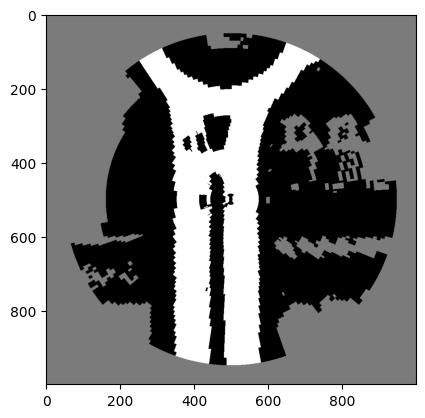

In [12]:
gt_image=predict(gt)
print(np.unique(gt_image))
print(np.unique(ogm_image))
plt.imshow(gt_image)

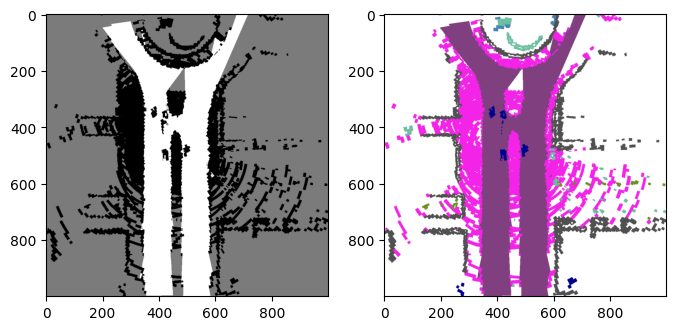

In [13]:
fig,axs = plt.subplots(1,2,figsize=(8,8))
axs[0].imshow(ogm_image)
axs[1].imshow(sgm_image)
plt.show()

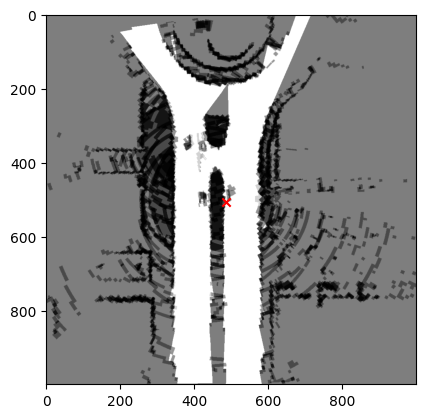

In [14]:
ogm=extract_occupancy_probability(ogm_mass)
plt.imshow(((1-ogm)*255).astype(np.uint8),cmap='gray')
plt.scatter(487,505,c='r',marker='x')

In [15]:
ogm[487,505]

0.4117647058823529

## visualize

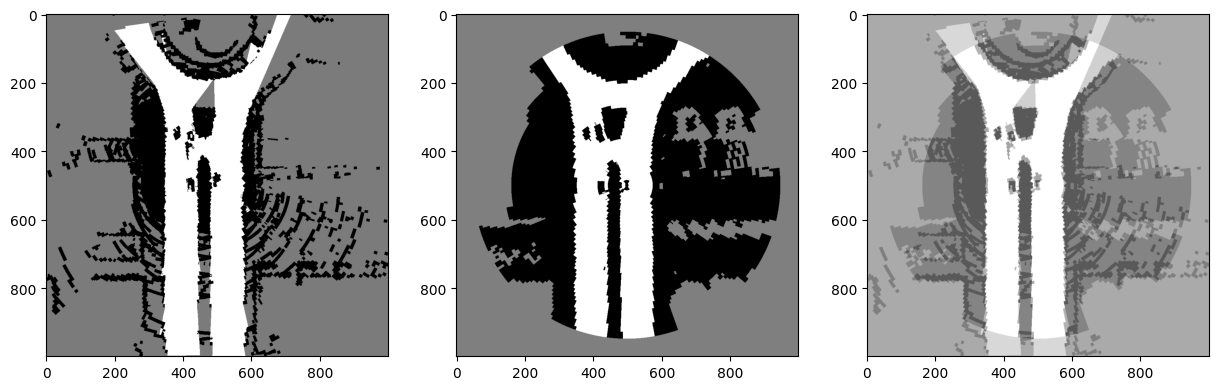

In [16]:
fig,axs = plt.subplots(1,3,figsize=(15,12))
axs[0].imshow(ogm_image,cmap='gray')
axs[1].imshow(((1-gt)*255).astype(np.uint8),cmap='gray')

axs[2].imshow(ogm_image,cmap='gray', alpha=0.5)
axs[2].imshow(((1-gt)*255).astype(np.uint8),cmap='gray', alpha=0.3)

plt.show()

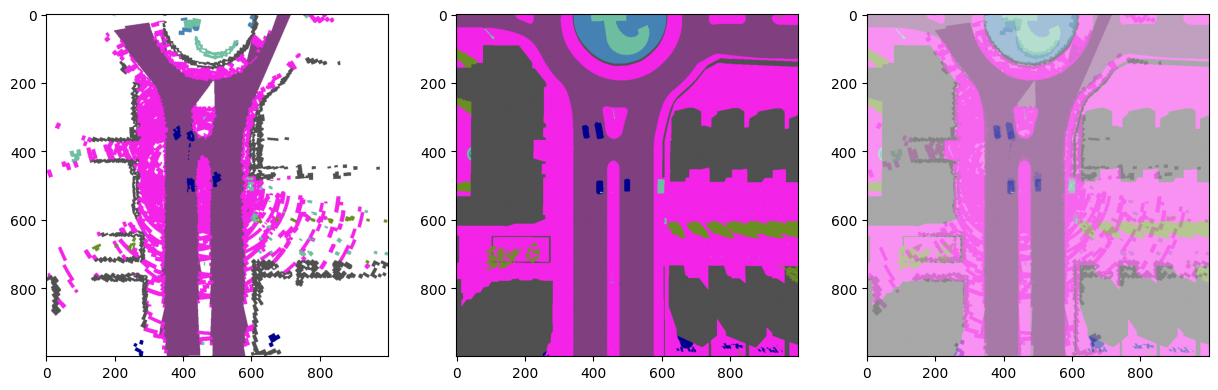

In [17]:
fig,axs = plt.subplots(1,3,figsize=(15,12))
axs[0].imshow(sgm_image)
axs[1].imshow(sgt_img)

axs[2].imshow(sgm_image, alpha=0.4)
axs[2].imshow(sgt_img, alpha=0.5)
plt.show()

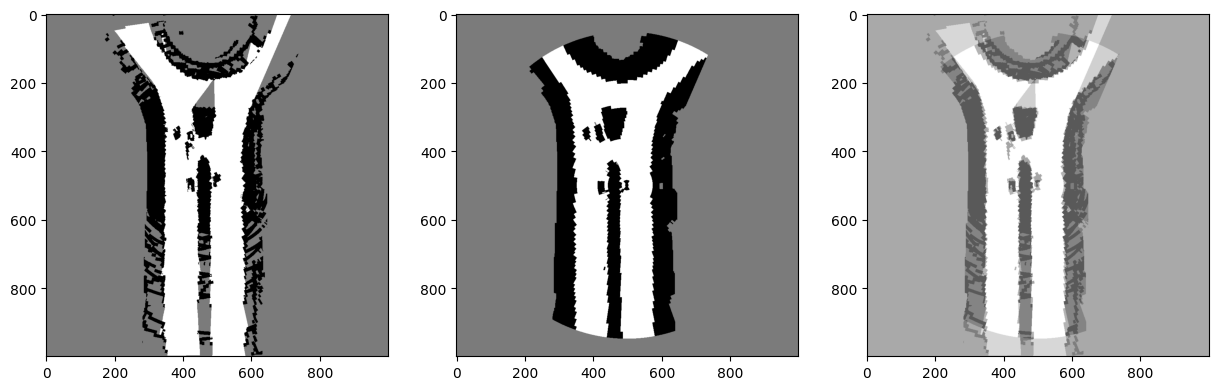

In [18]:
mask=generate_mask(ogm_image, 100)

gt_image_m = np.copy(gt_image)
gt_image_m[~mask] = (123,123,123)

ogm_image_m = np.copy(ogm_image)
ogm_image_m[~mask] = (123,123,123)



fig,axs = plt.subplots(1,3,figsize=(15,12))
axs[0].imshow(ogm_image_m,cmap='gray')
axs[1].imshow(gt_image_m)

axs[2].imshow(ogm_image_m,cmap='gray', alpha=0.5)
axs[2].imshow(gt_image_m, alpha=0.3)

plt.show()


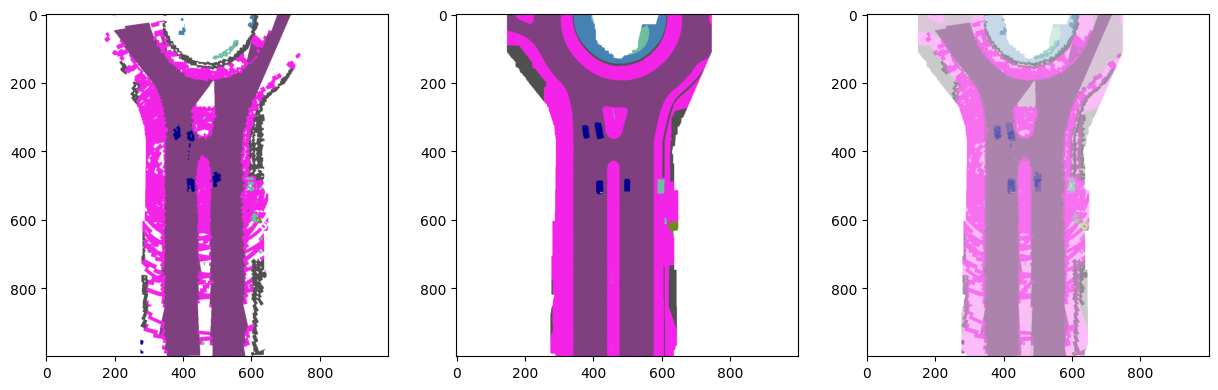

In [19]:
mask=generate_semantic_mask(sgm_image,110)

sgt_img_m = np.copy(sgt_img)
sgt_img_m[~mask] = (1,1,1)

sgm_image_m = np.copy(sgm_image/ 255.0)
sgm_image_m[~mask] = (1,1,1)



fig,axs = plt.subplots(1,3,figsize=(15,12))
axs[0].imshow(sgm_image_m)
axs[1].imshow(sgt_img_m)

axs[2].imshow(sgm_image_m, alpha=0.5)
axs[2].imshow(sgt_img_m, alpha=0.3)

plt.show()

## Evaluate

### Ogm

In [20]:
def evaluate_ogm_rgb(gt_image, pred_image):


    gt_occupied = np.all(gt_image == [0, 0, 0], axis=2)
    pred_occupied = np.all(pred_image == [0, 0, 0], axis=2)

    # Calculate metrics
    accuracy = np.sum(gt_occupied == pred_occupied) / gt_occupied.size

    # Calculate precision and recall
    true_positives = np.sum(np.logical_and(gt_occupied, pred_occupied))
    false_positives = np.sum(np.logical_and(np.logical_not(gt_occupied), pred_occupied))
    false_negatives = np.sum(np.logical_and(gt_occupied, np.logical_not(pred_occupied)))
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    # Compute F1 score
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Return evaluation metrics
    return accuracy, precision, recall, f1_score



# Evaluate the occupancy grid algorithm
accuracy, precision, recall, f1_score = evaluate_ogm_rgb(gt_image,ogm_image)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.771611
Precision: 0.8248910754378739
Recall: 0.41770909838714415
F1 Score: 0.5545862855114605


In [21]:
# Evaluate the occupancy grid algorithm
accuracy, precision, recall, f1_score = evaluate_ogm_rgb(gt_image_m,ogm_image_m)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.935967
Precision: 0.8905522961764111
Recall: 0.637030196948606
F1 Score: 0.7427536086325965


### Sgm

In [22]:
print(np.unique((sgm_image/255).reshape(-1, 3), axis=0))
print(np.unique(sgt_img.reshape(-1, 3), axis=0))

[[0.         0.         0.55686275]
 [0.2745098  0.50980392 0.70588235]
 [0.31372549 0.31372549 0.31372549]
 [0.41960784 0.55686275 0.1372549 ]
 [0.43137255 0.74509804 0.62745098]
 [0.50196078 0.25098039 0.50196078]
 [0.95686275 0.1372549  0.90980392]
 [1.         1.         1.        ]]
[[0.         0.         0.55686275]
 [0.2745098  0.50980392 0.70588235]
 [0.31372549 0.31372549 0.31372549]
 [0.41960784 0.55686275 0.1372549 ]
 [0.43137255 0.74509804 0.62745098]
 [0.50196078 0.25098039 0.50196078]
 [0.95686275 0.1372549  0.90980392]]


In [23]:
gt_classes = np.unique(sgt_img.reshape(-1, 3), axis=0)
pred_classes = np.unique(sgm_image.reshape(-1, 3), axis=0)

print(len(gt_classes))
print(len(pred_classes))

7
8


In [24]:
def evaluate_semantic_ogm_rgb(gt_image, pred_image):
    # Extract the unique classes present in the ground truth and predicted images
    gt_classes = np.unique(gt_image.reshape(-1, 3), axis=0)
    pred_classes = np.unique(pred_image.reshape(-1, 3), axis=0)

    # Combine the unique classes from both images
    classes = np.unique(np.concatenate((gt_classes, pred_classes), axis=0), axis=0)

    # Initialize evaluation metrics
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    # Iterate over each class
    for class_val in classes:
        # Create boolean masks for the current class in the ground truth and predicted images
        gt_mask = np.all(gt_image == class_val, axis=2)
        pred_mask = np.all(pred_image == class_val, axis=2)

        # Count true positives, false positives, and false negatives
        true_positives += np.sum(np.logical_and(gt_mask, pred_mask))
        true_negatives += np.sum(np.logical_and(np.logical_not(gt_mask), np.logical_not(pred_mask)))
        false_positives += np.sum(np.logical_and(np.logical_not(gt_mask), pred_mask))
        false_negatives += np.sum(np.logical_and(gt_mask, np.logical_not(pred_mask)))

    # Calculate precision, recall, and F1 score
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Return evaluation metrics
    return accuracy,precision, recall, f1_score

accuracy,precision, recall, f1_score = evaluate_semantic_ogm_rgb(sgt_img,sgm_image/255.)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.82778225
Precision: 0.311129
Recall: 0.311129
F1 Score: 0.311129


In [ ]:
accuracy,precision, recall, f1_score = evaluate_semantic_ogm_rgb(sgt_img_m,sgm_image_m)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")